# Project 1
# Data Mining

---------------------------------------------------------
---------------------------------------------------------

## Question 1
Collect training data from 20 Newsgroups data set, and plot a histogram of each label's occurances

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from matplotlib import pylab as plt
import matplotlib.colors as pltc
from itertools import cycle
import numpy as np 
np.random.seed(42) 
import random
random.seed(42)

In [2]:
twenty_train_dataset = fetch_20newsgroups(subset="train",
                                      shuffle=True,
                                      random_state=42)
twenty_test_dataset  = fetch_20newsgroups(subset="test",
                                     shuffle=True,
                                     random_state=42)
# bad choice of variable name.
cat_labels = np.unique(twenty_train_dataset.target)
print('Category labels present in the data set are: ', cat_labels)
num_classes = len(np.unique(twenty_train_dataset.target))
[freq_classes, _] = np.histogram(twenty_train_dataset.target,
                                 bins=np.arange(0,num_classes+1))

Category labels present in the data set are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


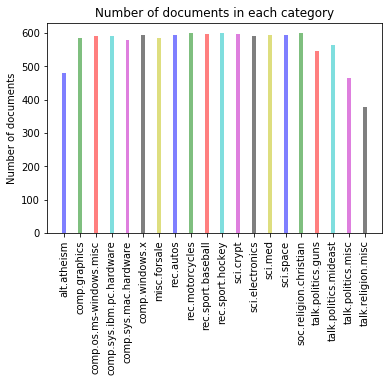

In [3]:
cycl = cycle('bgrcmky')
for i in range(len(cat_labels)):
    plt.bar([cat_labels[i]], [freq_classes[i]], width=0.25,
           align='center', color=next(cycl),
           alpha=0.5, label=twenty_train_dataset.target_names[i])
plt.xticks(cat_labels, twenty_train_dataset.target_names, rotation=90)
# plt.legend()
plt.ylabel('Number of documents')
plt.subplots_adjust(bottom= 0.22, top = 0.95)
plt.title("Number of documents in each category")
plt.show()

Based on the bar plot it appears the dataset is quite balanced except for religion, politcal misc categories. Let us quanify this by using entropy.

In [4]:
classes, count_classes = np.unique(twenty_train_dataset.target, return_counts=True)
n = len(twenty_train_dataset.target)
entropy = 0
for count in count_classes:
    entropy += -(count/n)*np.log(count/n)
estimate = entropy/np.log(len(classes))
print('estimate: ', estimate)

estimate:  0.9981706679371282


The closer the estimate is to 1 the better balanced is our dataset. We got 0.998 which is very high so our data set is quite balanced.

The first 4 categories are computer related (we will call this class 0) and the second 4 are recreation related (we will call this class 1).

## Question 2

#### The first and most important step in any Machine learning or Data Mining task is data extraction, data cleaning

#### The following tasks are performed as a part of Data Cleaning exercise.

* Remove words with frequency less than 3.
<br />
* Remove Stop words using the default CountVectorizer functions stop words (As specified in question)
<br />
* Perform Lemmatization using Wordnet's lemmatizer.

#### Feature Extraction 

* Formed the bag of words representation for our corpus.
* Normalized the frequency of each term based on importance (Term Frequency Inverse Document Frequency).

In [5]:
#Q2: Extract features w/ particular specifications
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk import pos_tag
from pickle import dump
from sklearn.datasets import fetch_20newsgroups


comp_categories = [ 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 
                   'comp.sys.mac.hardware']
rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset='train', categories=comp_categories+rec_categories, 
                                  shuffle=True, random_state=42,)
test_dataset = fetch_20newsgroups(subset='test', categories=comp_categories+rec_categories, 
                                 shuffle=True, random_state=42,)
counts = []

wnl = nltk.wordnet.WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

#NOTE: The following code was developed to remove all numbers (including floats like 6.7)
#      as isdigit doesn't work on floats. However, the floats it removed were:
#      ['35002_4401', '5e8', '5e9', '6e1', '9_6', 'inf', 'infinity']
#      So we decided not to use it
#def is_number(s):
#    try:
#        float(s)
#        return True
#    except:
#        return False

def rmv_nums(doc):
    #gets rid of numbers including floats
    #does lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag
    return (word for word in lemmatize_sent(analyzer(doc)) 
            if not word.isdigit())


#CountVectorizer returns a callable that handles preprocessing and tokenization
#Use the “english” stopwords of the CountVectorizer
vectorizer=CountVectorizer(analyzer=rmv_nums,min_df=3,stop_words='english')

#do feature extraction (train):
X_train_counts=vectorizer.fit_transform(train_dataset.data) #get matrix of doc-term counts (training data)
print('Size of training data after lemmatization but before TF-IDF: ', X_train_counts.shape) #4732 docs, 16292 terms (originally 4732 docs, 79218 terms)
X_test_counts=vectorizer.transform(test_dataset.data) 
print('Size of testing data after lemmatization but before TF-IDF:  ', X_test_counts.shape) #3150 docs, 16292 terms (originally 3150 docs, 79218 terms)

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print('Shape of train TF-IDF matrix: ',X_train_tfidf.shape)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print('Shape of test TF-IDF matrix:  ',X_test_tfidf.shape)

Size of training data after lemmatization but before TF-IDF:  (4732, 16600)
Size of testing data after lemmatization but before TF-IDF:   (3150, 16600)
Shape of train TF-IDF matrix:  (4732, 16600)
Shape of test TF-IDF matrix:   (3150, 16600)


As we can see, the shape of the category count matrices for the train and test data set are 4732x16600 and 3150x16600 respectively.
In addition, the shape doesn't change once the TF-IDF transform is applied.

## Question 3: Dimensionality Reduction

* To escape from the Curse of Dimensionality we perform Dimensionality reduction.<br />
* We have used 2 Dimensionality reduction techniques <br />
    1) Latent Semantic Analysis <br />
    2) Non-Negative Matrix Factorization 

#### Latent Semantic Analysis

Do dimensionality reduction with LSA/LSI. In this part of code, I created the SVD object and transform the test date into a reduced version of itself.

In [6]:
#Q3
#LSA
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
X_train_LSA = svd.fit_transform(X_train_tfidf)
X_test_LSA = svd.transform(X_test_tfidf)
print('SVD reduced training set shape: ', X_train_LSA.shape)
print('SVD reduced testing set shape:  ', X_test_LSA.shape)

V = svd.components_

SVD reduced training set shape:  (4732, 50)
SVD reduced testing set shape:   (3150, 50)


In [7]:
LSA_train_error=np.sum(np.array(X_train_tfidf - X_train_LSA.dot(V))**2)
LSA_test_error=np.sum(np.array(X_test_tfidf - X_test_LSA.dot(V))**2)

print('Error from LSA training set: ', LSA_train_error)
print('Error from LSA testing set:  ', LSA_test_error)

Error from LSA training set:  3895.4186796933277
Error from LSA testing set:   2676.4912327221027


#### Non Negative Matrix Factorization

Do dimensionality reduction with NMF. Make the NMF object, which find a W and H, and then uses H to transform the test data too.

In [8]:
#Q3 cont
#NMF
from sklearn.decomposition import NMF
nmf = NMF(n_components=50, init='random', random_state=42)

W_train = nmf.fit_transform(X_train_tfidf) #Find our W and H from the train data
W_test  = nmf.transform(X_test_tfidf) #apply the found H and do the minimization

H = nmf.components_

print('NMF reduced (W) training set shape: ', W_train.shape)
print('NMF reduced (W) testing set shape:  ', W_test.shape)
print('NMF reduced (H) set shape:          ', H.shape)

NMF reduced (W) training set shape:  (4732, 50)
NMF reduced (W) testing set shape:   (3150, 50)
NMF reduced (H) set shape:           (50, 16600)


In [9]:
#Get NMF error
NMF_train_error = np.sum(np.array(X_train_tfidf - W_train.dot(H))**2)
NMF_test_error = np.sum(np.array(X_test_tfidf - W_test.dot(H))**2)

print('Error from NMF training set: ', NMF_train_error)
print('Error from NMF testing set:  ', NMF_test_error)

Error from NMF training set:  3940.342513932875
Error from NMF testing set:   2689.0690267386613


Both NMF and LSA considers linear combination of 50 base vectors to represent the data but in case of NMF it takes postive linear combination to get more interpretable results (Partly NMF is inspired from the way our brain works). So NMF gives slightly more Error compared to LSA as NMF considers postive coefficients only.

## Question 4: Classification Algorithms

In [56]:
#Question 4
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc

y_train = train_dataset.target > 3
y_train = y_train.astype(int)
y_test = test_dataset.target > 3
y_test = y_test.astype(int)

#hard
clf_hard = LinearSVC(C=1000, random_state=42).fit(X_train_LSA, y_train)
y_pred_hard = clf_hard.predict(X_test_LSA)
scores_hard = clf_hard.decision_function(X_test_LSA)

#soft
clf_soft = LinearSVC(C=0.0001, random_state=42).fit(X_train_LSA, y_train)
y_pred_soft = clf_soft.predict(X_test_LSA)
scores_soft = clf_soft.decision_function(X_test_LSA)

#### ROC Curve

area under hard svm curve 0.9956712626995645
area under soft svm curve 0.968452668924367


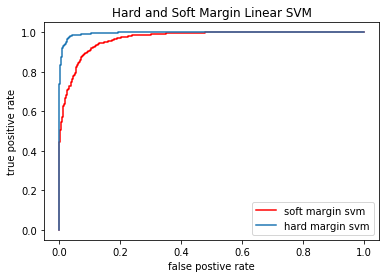

In [57]:
# roc curve:
fpr_hard, tpr_hard, thresholds_hard = roc_curve(y_test, scores_hard)
fpr_soft, tpr_soft, thresholds_soft = roc_curve(y_test, scores_soft)

# area under the curve:
roc_auc_hard = auc(fpr_hard,tpr_hard)
roc_auc_soft = auc(fpr_soft,tpr_soft)
print("area under hard svm curve", roc_auc_hard)
print("area under soft svm curve", roc_auc_soft)

# plot roc curves:

plt.plot(fpr_soft, tpr_soft, 'r', label='soft margin svm')
plt.plot(fpr_hard, tpr_hard, label='hard margin svm')
plt.legend()
plt.title('Hard and Soft Margin Linear SVM')
plt.xlabel('false postive rate')
plt.ylabel('true positive rate')
plt.show()

##### Observation: As we want the area under the ROC curve to be high, Hard margin SVM is a better choice in this problem.

#### Confusion Matrix

In [58]:
confusion_hard = confusion_matrix(y_test, y_pred_hard)
confusion_soft = confusion_matrix(y_test, y_pred_soft)

In [59]:
#confusion matrix plot
import itertools

def plot_confusion_matrix(cm, title, cmap = plt.cm.Blues):
    ctgrs = ['Class I \n Computers','Class II \n Recreation']
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title + ', without normalization')
    plt.colorbar()
    tick_marks = np.arange(len(ctgrs))
    plt.xticks(tick_marks, ctgrs, rotation=45)
    plt.yticks(tick_marks, ctgrs)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

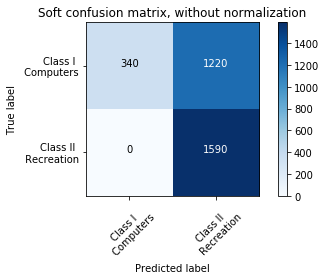

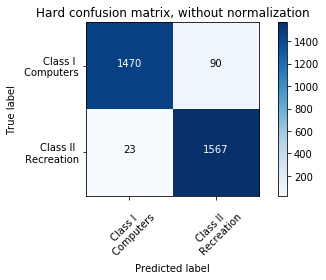

In [60]:
# Plot non-normalized confusion matrices
plot_confusion_matrix(confusion_soft, title='Soft confusion matrix')
plot_confusion_matrix(confusion_hard, title='Hard confusion matrix')

#### Accuracy, Recall, Precision and F1 Score

In [61]:
#hard
accuracy_hard  = accuracy_score(y_test, y_pred_hard)
recall_hard    = recall_score(y_test, y_pred_hard)
precision_hard = precision_score(y_test, y_pred_hard)
f1_score_hard  = f1_score(y_test, y_pred_hard)

#soft
accuracy_soft = accuracy_score(y_test, y_pred_soft)
recall_soft = recall_score(y_test, y_pred_soft)
precision_soft = precision_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print('Hard accuracy:  ', accuracy_hard,  '    Soft accuracy:  ', accuracy_soft)
print('Hard recall:    ', recall_hard,    '     Soft recall:    ', recall_soft)
print('Hard precision: ', precision_hard, '    Soft precision: ', precision_soft)
print('Hard F1 score:  ', f1_score_hard,  '    Soft F1 score:  ', f1_score_soft)

Hard accuracy:   0.9641269841269842     Soft accuracy:   0.6126984126984127
Hard recall:     0.9855345911949686      Soft recall:     1.0
Hard precision:  0.9456849728424864     Soft precision:  0.5658362989323843
Hard F1 score:   0.9651986449029875     Soft F1 score:   0.7227272727272728


#### Clearly we can see from the ROC curve and Confusion matrix Hard Margin SVM is better than Soft margin SVM.

The reason why Soft margin SVM performed very badly is as follows:

1) When we decrease the gamma parameter we allow classification errors to take place while decreasing the objective function that is norm of weight vector (try to increase the margin)

2) When we kept the gamma to be very low, the classifier made a lot of errors (gamma very low so no penality) while decreasing the objective function that is norm of weight vector (try to increase the margin).

So at gamma at 0.001 we got very poor accuracy. So gamma has to be tuned shouldn't be too less or high.

In [73]:
from sklearn.model_selection import cross_val_score
scores_k = []
for k in range(-3,4):
    clf_svm = LinearSVC(C=10**k).fit(X_train_LSA, y_train)
    scores = cross_val_score(clf_svm, X_train_LSA, y_train, cv=5, scoring='accuracy')
    scores_k.append(np.mean(scores))
k_opt = 10**(np.argmax(scores_k)-3)
print(k_opt)

10


#### Optimal Value of C is 10.

In [64]:
clf_svm_opt = LinearSVC(C=k_opt, random_state=42).fit(X_train_LSA, y_train)
y_pred_svm_opt = clf_svm_opt.predict(X_test_LSA)
scores_svm_opt = clf_svm_opt.decision_function(X_test_LSA)

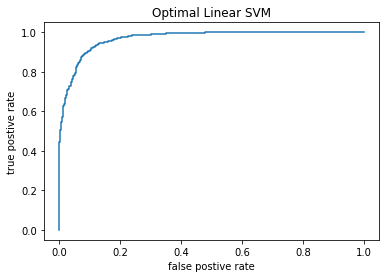

In [65]:
# roc curve:
fpr_opt, tpr_opt, thresholds_opt = roc_curve(y_test, scores_svm_opt)
# plot roc curves:
plt.plot(fpr_soft, tpr_soft, label='svm')
plt.title('Optimal Linear SVM')
plt.xlabel('false postive rate')
plt.ylabel('true postive rate')
plt.show()

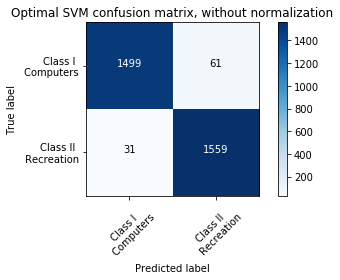

In [71]:
# Plot non-normalized confusion matrices
confusion_opt = confusion_matrix(y_test, y_pred_svm_opt)
plot_confusion_matrix(confusion_opt, title='Optimal SVM confusion matrix')

In [66]:
accuracy_opt = accuracy_score(y_test, y_pred_svm_opt)
recall_opt = recall_score(y_test, y_pred_svm_opt)
precision_opt = precision_score(y_test, y_pred_svm_opt)
f1_score_opt = f1_score(y_test, y_pred_svm_opt)

print('Optimal SVM accuracy:  ', accuracy_opt)
print('Optimal SVM recall:    ', recall_opt)
print('Optimal SVM precision: ', precision_opt)
print('Optimal SVM F1 score:  ', f1_score_opt)

Optimal SVM accuracy:   0.9707936507936508
Optimal SVM recall:     0.980503144654088
Optimal SVM precision:  0.9623456790123457
Optimal SVM F1 score:   0.9713395638629283


#### Accuracy increased from 96.4% to 97.07% by using Optimal Threshold (C is 10) SVM instead of Hard threshold SVM.

## Question 5

In [85]:
#Combined code from Eden and Sarat
from sklearn.linear_model import LogisticRegression

# C very high value to simulate no regularization
clf = LogisticRegression(C=1e10, random_state=42)
clf.fit(X_train_LSA, y_train)
y_pred = clf.predict(X_test_LSA)
unrg_scores_prob = clf.predict_proba(X_test_LSA)[:, 1]


predicted = y_pred[20:30]
print('predicted: ', predicted)
print('actual:    ', y_test[20:30])

predicted:  [1 1 1 0 0 1 1 0 0 1]
actual:     [1 1 1 0 0 1 1 0 0 1]


area under losgitc regression curve 0.9958655861957749


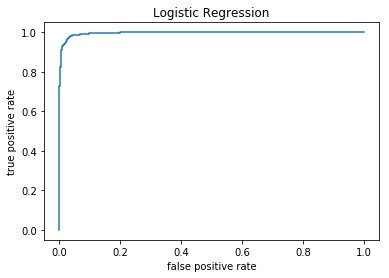

In [83]:
# roc curve:
fpr, tpr, thresholds = roc_curve(
    y_test, unrg_scores_prob)

# area under the curve:
roc_auc = auc(fpr,tpr)
print("area under losgitc regression curve", roc_auc)

# plot roc curves:
plt.plot(fpr, tpr)
plt.title('Logistic Regression')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [84]:
#defining logitistic types
unreg_confusion = confusion_matrix(y_test, y_pred)
unreg_accuracy = accuracy_score(y_test, y_pred)
unreg_recall = recall_score(y_test, y_pred)
unreg_precision = precision_score(y_test, y_pred)
unreg_f1_score = f1_score(y_test, y_pred)

print('Accuracy logistic:  ', unreg_accuracy) #
print('Recall logistic:    ', unreg_recall) #
print('Precision logistic: ', unreg_precision) #
print('F1 score logistic:  ', unreg_f1_score) #


Accuracy logistic:   0.9714285714285714
Recall logistic:     0.9792452830188679
Precision logistic:  0.9646840148698885
F1 score logistic:   0.9719101123595505


### Classifiers with Regularization

#### L1 Regularization

In [19]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from math import log

C_pot = [0.001, 0.01, 0.1, 1, 10, 100, 1000] #potential regularization strengths for k=[-3,3] 
clf_l1 = LogisticRegressionCV(Cs=C_pot, cv=5, penalty='l1', refit=True,
                                       solver='liblinear', random_state=42)
clf_l1_test_score = []
clf_l1.fit(X_train_LSA, y_train)
for C_pot1 in C_pot:
    clf_l1_2= LogisticRegressionCV(Cs=[C_pot1], cv=5, penalty='l1', refit=True,
                                       solver='liblinear', random_state=42)
    clf_l1_2.fit(X_train_LSA, y_train)
    clf_l1_test_score.append(clf_l1_2.score(X_test_LSA, y_test))

scores_l1_5fold = clf_l1.scores_
c_opt_l1 = clf_l1.C_[0]
k_opt_l1= log(c_opt_l1, 10)
inv_c_opt_l1 = c_opt_l1**-1 #Each of the values in Cs describes the inverse of regularization strength
print('Optimal k-value for L1: ', k_opt_l1)
print('Optimal C-value: ', 10**k_opt_l1)
print('This corresponds to an optimal regularization strength for L1 (inverse of C=10^k): ', 
      inv_c_opt_l1)

Optimal k-value for L1:  1.0
Optimal C-value:  10.0
This corresponds to an optimal regularization strength for L1 (inverse of C=10^k):  0.1


In [ ]:
clf_l1

Text(0.5,1,'Cross Validation Error rate vs L1 Regularization strength')

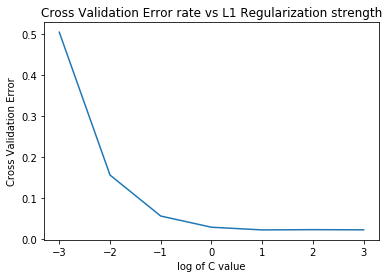

In [87]:
scores_l1 = []
for l in range(0,7):
    scores_l1.append(np.mean(scores_l1_5fold[1][:,l]))
k_values = range(-3,4)
plt.plot(np.asarray(k_values), 1-np.asarray(scores_l1))
plt.xlabel("log of C value")
plt.ylabel("Cross Validation Error")
plt.title("Cross Validation Error rate vs L1 Regularization strength")

Text(0.5, 1.0, 'Test Error rate vs L1 Regularization strength')

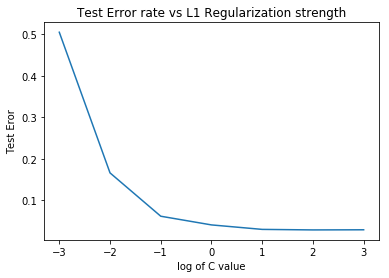

In [20]:
k_values = range(-3,4)
plt.plot(np.asarray(k_values), 1-np.asarray(clf_l1_test_score))
plt.xlabel("log of C value")
plt.ylabel("Test Eror")
plt.title("Test Error rate vs L1 Regularization strength")

We see in the plot above that regularization decreases the test error.

#### L2 Regularization

In [88]:
clf_l2 = LogisticRegressionCV(Cs=C_pot, cv=5, penalty='l2', refit=True,
                                       solver='liblinear', random_state=42)
clf_l2.fit(X_train_LSA, y_train)
scores_l2_5fold = clf_l2.scores_
c_opt_l2 = clf_l2.C_[0]
k_opt_l2= log(c_opt_l2, 10)
inv_c_opt_l2 = c_opt_l2**-1 #Each of the values in Cs describes the inverse of 
                            #regularization strength

print('Optimal k-value for L2: ', k_opt_l2)
print('Optimal C-value: ', c_opt_l2)
print('This corresponds to an optimal regularization strength for L2 (inverse of C=10^k): ', 
      inv_c_opt_l2)

Optimal k-value for L2:  2.0
Optimal C-value:  100.0
This corresponds to an optimal regularization strength for L2 (inverse of C=10^k):  0.01


Text(0.5,1,'Cross Validation Error rate vs L2 Regularization strength')

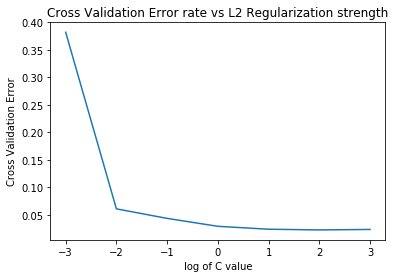

In [89]:
scores_l2 = []
for i in range(0,7):
    scores_l2.append(np.mean(scores_l2_5fold[1][:,i]))
plt.plot(np.asarray(k_values), 1-np.asarray(scores_l2))
plt.xlabel("log of C value")
plt.ylabel("Cross Validation Error")
plt.title("Cross Validation Error rate vs L2 Regularization strength")

Text(0.5, 1.0, 'Test Error rate vs L2 Regularization strength')

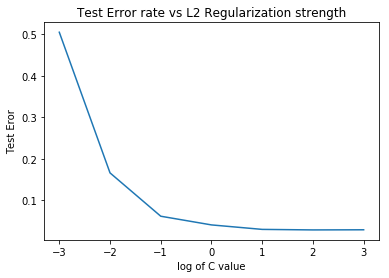

In [22]:
clf_l2_test_score = []
clf_l2.fit(X_train_LSA, y_train)
for C_pot1 in C_pot:
    clf_l2_2= LogisticRegressionCV(Cs=[C_pot1], cv=5, penalty='l1', refit=True,
                                       solver='liblinear', random_state=42)
    clf_l2_2.fit(X_train_LSA, y_train)
    clf_l2_test_score.append(clf_l2_2.score(X_test_LSA, y_test))

k_values = range(-3,4)
plt.plot(np.asarray(k_values), 1-np.asarray(clf_l2_test_score))
plt.xlabel("log of C value")
plt.ylabel("Test Eror")
plt.title("Test Error rate vs L2 Regularization strength")

#### From the figure above we can clearly see as we increase the Regularization strength the cross validation error decreases.

In [90]:
#Find the performance of best L1, best L2, No regularization test set performance

#L1:
clf_l1_opt    = LogisticRegression(penalty='l1', C=c_opt_l1, solver='liblinear', 
                                            random_state=42)
clf_l1_opt.fit(X_train_LSA, y_train)
y_pred_l1_opt = clf_l1_opt.predict(X_test_LSA)
scores_l1_opt = clf_l1_opt.decision_function(X_test_LSA)

#L2
clf_l2_opt    = LogisticRegression(C=c_opt_l2, penalty='l2', solver='liblinear', 
                                            random_state=42)
clf_l2_opt.fit(X_train_LSA, y_train)
y_pred_l2_opt = clf_l2_opt.predict(X_test_LSA)
scores_l2_opt = clf_l2_opt.decision_function(X_test_LSA)

#L1: accuracy, recall, precision, f1 score
accuracy_l1_opt  = accuracy_score(y_test, y_pred_l1_opt)
recall_l1_opt    = recall_score(y_test, y_pred_l1_opt)
precision_l1_opt = precision_score(y_test, y_pred_l1_opt)
f1_score_l1_opt  = f1_score(y_test, y_pred_l1_opt)

#L2: accuracy, recall, precision, f1 score
accuracy_l2_opt  = accuracy_score(y_test, y_pred_l2_opt)
recall_l2_opt    = recall_score(y_test, y_pred_l2_opt)
precision_l2_opt = precision_score(y_test, y_pred_l2_opt)
f1_score_l2_opt  = f1_score(y_test, y_pred_l2_opt)

print(' Accuracy score for unregularized: ', unreg_accuracy, '\n', 
      '                          for l1: ', accuracy_l1_opt, '\n', 
      '                          for l2: ', accuracy_l2_opt)
print('   Recall score for unregularized: ', unreg_recall, '\n',
      '                          for l1: ', recall_l1_opt, '\n',
      '                          for l2: ',  recall_l2_opt)
print('Precision score for unregularized: ', unreg_precision, '\n',
      '                          for l1: ', precision_l1_opt, '\n',
      '                          for l2: ', precision_l2_opt)
print('       F1 score for unregularized: ', unreg_f1_score, '\n',
      '                          for l1: ', f1_score_l1_opt, '\n',
      '                          for l2: ', f1_score_l2_opt)

 Accuracy score for unregularized:  0.9714285714285714 
                           for l1:  0.9704761904761905 
                           for l2:  0.9701587301587301
   Recall score for unregularized:  0.9792452830188679 
                           for l1:  0.9817610062893082 
                           for l2:  0.9817610062893082
Precision score for unregularized:  0.9646840148698885 
                           for l1:  0.9606153846153846 
                           for l2:  0.9600246002460024
       F1 score for unregularized:  0.9719101123595505 
                           for l1:  0.971073094867807 
                           for l2:  0.9707711442786069


Refer to the Report for analysis of Question5.

## Quesiton 6
Do binary classification with (Gaussian) Naive Bayes. Fits a Gaussian probability model to the given features to estimate the classes. Fit and predict.

In [29]:
from sklearn.naive_bayes import GaussianNB

NBclsfr = GaussianNB()
NBclsfr.fit(X_train_LSA, y_train)
y_pred_nb = NBclsfr.predict(X_test_LSA)
NB_scores_prob = NBclsfr.predict_proba(X_test_LSA)[:, 1]

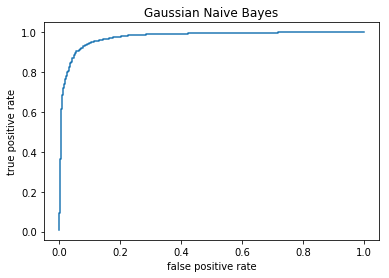

In [30]:
# roc curve:
fpr_gaussian_nb, tpr_gaussian_nb, thresholds_gaussian_nb = roc_curve(
    y_test, NB_scores_prob)

# plot roc curves:
plt.plot(fpr_gaussian_nb, tpr_gaussian_nb)
plt.title('Gaussian Naive Bayes')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

Accuracy of (Gaussian) Naive Bayes:   0.9015873015873016
Recall of (Gaussian) Naive Bayes:     0.9723270440251572
Precision of (Gaussian) Naive Bayes:  0.8532008830022075
F1 score of (Gaussian) Naive Bayes:   0.9088771310993533


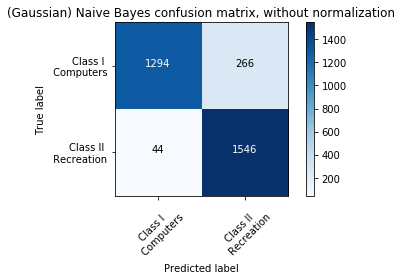

In [31]:
confusion_nb = confusion_matrix(y_test, y_pred_nb)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
f1_score_nb = f1_score(y_test, y_pred_nb)

plot_confusion_matrix(confusion_nb, title='(Gaussian) Naive Bayes confusion matrix')

print('Accuracy of (Gaussian) Naive Bayes:  ', accuracy_nb)
print('Recall of (Gaussian) Naive Bayes:    ', recall_nb)
print('Precision of (Gaussian) Naive Bayes: ', precision_nb)
print('F1 score of (Gaussian) Naive Bayes:  ', f1_score_nb)

## Question 7
Grid search paramters to make it easier to optimize. 
- Construct a pipeline to f=perform feature extraction, dimensionality reduction and classification
- Do grid search with 5-fold cross-validation to compare
    - removed headers and footers vs not
    - min_df = 3 or 5
    - lemmatization or not
    - LSI or NMF
    - SVM with the previously found gamma or L1 log or L2 log or GaussianNB
    - else default

In [32]:
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import time

pipeline = Pipeline([
    ('vector', CountVectorizer(analyzer=rmv_nums, #toggle this and 'word'
                               min_df=3, #toggle min_df
                               stop_words='english')),
    ('tf-idf', TfidfTransformer()), # toggle this and  NMF
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('classify', GaussianNB()),    #toggle this and log reg's and SVM 
])


param_grid = [
    {
        'vector__analyzer': [rmv_nums, 'word'], # lemmatizations vs not
        'vector__min_df': [3,5], # min df is 3 vs 5
        'reduce_dim': [TruncatedSVD(n_components=50, random_state=42),
                       NMF(n_components=50, init='random', random_state=42)],
        'classify': [GaussianNB(), # Gaussian Naive Bayes
                     LinearSVC(C=10, random_state=42), # SVC
                     LogisticRegression(penalty='l1', random_state=42, solver='liblinear', C=10),
                     LogisticRegression(penalty='l2', random_state=42, solver='liblinear', C=100)]
    }
]

In [33]:
grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_grid, verbose=5, 
                    scoring='accuracy')

In [34]:
start = time.time()
grid.fit(train_dataset.data, y_train)
end = time.time()
print("run time is: ", end-start)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV] classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV] classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV] classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV]  classify=GaussianNB(priors=None), reduce_dim

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  7.6min


[CV]  classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3, score=0.9154334038054969, total=   3.2s
[CV] classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3 
[CV]  classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3, score=0.9155227032734953, total=   3.7s
[CV] classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=5 
[CV]  classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analy

  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=5 
[CV]  classify=GaussianNB(priors=None), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=5, score=0.938753959873284, total= 2.5min
[CV] classify=GaussianNB(priors=None), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=3 
[CV]  classify=GaussianNB(priors=None), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_

  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=5, score=0.9408033826638478, total= 1.0min
[CV] classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV]  classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3, score=0.9714889123548046, total= 2.1min
[CV] classify=Linea

       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3, score=0.9746568109820486, total=   3.2s
[CV] classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3 
[CV]  classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3, score=0.9757127771911299, total=   3.6s
[CV] classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     inter

       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=5, score=0.9767195767195768, total= 2.1min
[CV] classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV]  classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 40.0min


[CV]  classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3, score=0.9682539682539683, total= 3.0min
[CV] classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min

       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3, score=0.9799366420274551, total= 2.2min
[CV] classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=5 
[CV]  classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vecto

       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3, score=0.9767687434002112, total=   2.8s
[CV] classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3 
[CV]  classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3, score=0.9725158562367865, tota

       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=5, score=0.9777777777777777, total= 1.9min
[CV] classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV]  classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frob

  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=3 
[CV]  classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=5, score=0.9725448785638859, total= 2.7min
[CV] classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ra

  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=5 
[CV]  classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=3, score=0.9735449735449735, total= 1.1min
[CV] classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_compon

       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3, score=0.96723044397463, total= 1.9min
[CV] classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=5 
[CV]  classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vecto

       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3, score=0.9798941798941799, total=   3.0s
[CV] classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=5 
[CV]  classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=5, score=0.9704329461457233, to

  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV]  classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3, score=0.9640971488912354, total= 2.6min
[CV] classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_los

  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=3, score=0.9609292502639916, total=  56.7s
[CV] classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=3 
[CV]  classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_comp

  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=5, score=0.9704329461457233, total=  59.2s
[CV]  classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=5, score=0.9693121693121693, total=  25.1s
[CV]  classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='rand

[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 102.2min finished


run time is:  6190.921961069107


In [35]:
import pandas as pd

pd.DataFrame(grid.cv_results_)

/home/sarat/packages/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/sarat/packages/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/sarat/packages/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/s

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify,param_reduce_dim,param_vector__analyzer,param_vector__min_df,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,97.433782,1.983841,24.230762,1.497332,GaussianNB(priors=None),"TruncatedSVD(algorithm='randomized', n_compone...",<function rmv_nums at 0x7f916a205e18>,3,"{'classify': GaussianNB(priors=None), 'reduce_...",0.928194,...,0.898563,0.042416,31,0.929458,0.906737,0.842272,0.907818,0.930024,0.903262,0.032109
1,102.119900,1.218594,24.499773,1.311629,GaussianNB(priors=None),"TruncatedSVD(algorithm='randomized', n_compone...",<function rmv_nums at 0x7f916a205e18>,5,"{'classify': GaussianNB(priors=None), 'reduce_...",0.920803,...,0.880389,0.048132,32,0.917834,0.885337,0.833554,0.873217,0.924743,0.886937,0.032938
2,3.210907,0.282175,0.433967,0.045136,GaussianNB(priors=None),"TruncatedSVD(algorithm='randomized', n_compone...",word,3,"{'classify': GaussianNB(priors=None), 'reduce_...",0.884900,...,0.912933,0.015050,30,0.904888,0.928402,0.913342,0.912044,0.894904,0.910716,0.011004
3,2.898037,0.171780,0.363549,0.027997,GaussianNB(priors=None),"TruncatedSVD(algorithm='randomized', n_compone...",word,5,"{'classify': GaussianNB(priors=None), 'reduce_...",0.920803,...,0.913145,0.014795,29,0.923910,0.919947,0.896697,0.886424,0.918669,0.909130,0.014809
4,148.772296,5.360785,25.577251,1.781800,GaussianNB(priors=None),"NMF(alpha=0.0, beta_loss='frobenius', init='ra...",<function rmv_nums at 0x7f916a205e18>,3,"{'classify': GaussianNB(priors=None), 'reduce_...",0.936642,...,0.938081,0.006604,28,0.936856,0.937649,0.942668,0.938193,0.942171,0.939507,0.002421
5,135.187867,9.174068,22.972236,1.775968,GaussianNB(priors=None),"NMF(alpha=0.0, beta_loss='frobenius', init='ra...",<function rmv_nums at 0x7f916a205e18>,5,"{'classify': GaussianNB(priors=None), 'reduce_...",0.952482,...,0.942096,0.005966,26,0.944782,0.940026,0.937120,0.937929,0.933721,0.938716,0.003651
6,73.791991,16.335032,0.780611,0.193678,GaussianNB(priors=None),"NMF(alpha=0.0, beta_loss='frobenius', init='ra...",word,3,"{'classify': GaussianNB(priors=None), 'reduce_...",0.949314,...,0.943576,0.005214,25,0.944782,0.946631,0.942404,0.946117,0.942435,0.944474,0.001783
7,59.657339,15.056507,0.694482,0.133898,GaussianNB(priors=None),"NMF(alpha=0.0, beta_loss='frobenius', init='ra...",word,5,"{'classify': GaussianNB(priors=None), 'reduce_...",0.951426,...,0.939772,0.007733,27,0.947952,0.940819,0.933421,0.942684,0.935833,0.940142,0.005131
8,100.699575,2.238069,25.299938,1.681110,"LinearSVC(C=10, class_weight=None, dual=True, ...","TruncatedSVD(algorithm='randomized', n_compone...",<function rmv_nums at 0x7f916a205e18>,3,"{'classify': LinearSVC(C=10, class_weight=None...",0.971489,...,0.975063,0.004566,1,0.979128,0.976222,0.978071,0.980718,0.978083,0.978445,0.001473
9,100.648767,1.831733,25.563081,1.382796,"LinearSVC(C=10, class_weight=None, dual=True, ...","TruncatedSVD(algorithm='randomized', n_compone...",<function rmv_nums at 0x7f916a205e18>,5,"{'classify': LinearSVC(C=10, class_weight=None...",0.972545,...,0.973795,0.005241,8,0.978336,0.975958,0.978071,0.979398,0.978875,0.978127,0.001177


Remove header and footer from Data

In [36]:
train_dataset_noheaders = fetch_20newsgroups(subset = 'train', 
                                   categories=comp_categories+rec_categories, 
                                   remove=('headers', 'footers'), #toggle head/foot
                                   shuffle = True, 
                                   random_state = None)
test_dataset_noheaders = fetch_20newsgroups(subset = 'test',
                                  categories=comp_categories+rec_categories, 
                                  remove=('headers', 'footers'), #toggle head/foot
                                  shuffle = True, 
                                  random_state = None)

In [37]:
y_train_noheaders = train_dataset_noheaders.target > 3
y_test_noheaders = test_dataset_noheaders.target > 3

In [38]:
grid1 = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_grid, verbose=5, scoring='accuracy')
start = time.time()
grid1.fit(train_dataset_noheaders.data, y_train_noheaders)
end = time.time()
print("run time is: ", end-start)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV] classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV] classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV] classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV]  classify=GaussianNB(priors=None), reduce_dim

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.3min


[CV]  classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3, score=0.8289334741288279, total=   2.2s
[CV] classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3 
[CV]  classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3, score=0.8625792811839323, total=   2.5s
[CV] classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=5 
[CV]  classify=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analy

  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=5 
[CV]  classify=GaussianNB(priors=None), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=5, score=0.9514255543822597, total= 1.8min
[CV] classify=GaussianNB(priors=None), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=3 
[CV]  classify=GaussianNB(priors=None), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min

  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=5, score=0.9386892177589852, total=  34.6s
[CV] classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV]  classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3, score=0.9609292502639916, total= 1.6min
[CV] classify=Linea

       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3, score=0.9757127771911299, total=   2.2s
[CV] classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3 
[CV]  classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3, score=0.9736008447729673, total=   2.4s
[CV] classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     inter

       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=5, score=0.9693121693121693, total= 1.5min
[CV] classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV]  classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 28.1min


[CV]  classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=5, score=0.9440337909186906, total= 2.0min
[CV] classify=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min

       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3, score=0.9736008447729673, total= 1.5min
[CV] classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=5 
[CV]  classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vecto

       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3, score=0.9736008447729673, total=   2.1s
[CV] classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3 
[CV]  classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3, score=0.9693446088794926, tota

       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=5, score=0.9682539682539683, total= 1.5min
[CV] classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV]  classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frob

  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=3 
[CV]  classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=5, score=0.9577613516367476, total= 2.1min
[CV] classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ra

  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=5 
[CV]  classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=5, score=0.9725448785638859, total=  39.3s
[CV] classify=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_compon

       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3, score=0.9619450317124736, total= 1.5min
[CV] classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=5 
[CV]  classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vec

       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=3, score=0.9777777777777777, total=   2.2s
[CV] classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=5 
[CV]  classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), vector__analyzer=word, vector__min_df=5, score=0.9683210137275607, to

  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3 
[CV]  classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=<function rmv_nums at 0x7f916a205e18>, vector__min_df=3, score=0.9482576557550159, total= 2.1min
[CV] classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_los

  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=3, score=0.9545934530095037, total=  40.6s
[CV] classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=3 
[CV]  classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_comp

  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=3, score=0.9746031746031746, total= 1.0min
[CV]  classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vector__analyzer=word, vector__min_df=5, score=0.9577613516367476, total=  35.7s
[CV]  classify=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='rand

[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 78.5min finished


run time is:  4713.318192720413


In [39]:
import pandas as pd

pd.DataFrame(grid1.cv_results_)

/home/sarat/packages/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/sarat/packages/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/sarat/packages/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/s

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify,param_reduce_dim,param_vector__analyzer,param_vector__min_df,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,68.918805,1.473694,17.130332,1.295791,GaussianNB(priors=None),"TruncatedSVD(algorithm='randomized', n_compone...",<function rmv_nums at 0x7f916a205e18>,3,"{'classify': GaussianNB(priors=None), 'reduce_...",0.795143,...,0.789730,0.025894,32,0.840159,0.816116,0.815588,0.834390,0.842355,0.829722,0.011621
1,71.471251,3.122685,17.592586,1.903124,GaussianNB(priors=None),"TruncatedSVD(algorithm='randomized', n_compone...",<function rmv_nums at 0x7f916a205e18>,5,"{'classify': GaussianNB(priors=None), 'reduce_...",0.788807,...,0.800719,0.021607,31,0.837781,0.827477,0.833554,0.825938,0.851334,0.835216,0.009112
2,1.974024,0.201522,0.257087,0.016740,GaussianNB(priors=None),"TruncatedSVD(algorithm='randomized', n_compone...",word,3,"{'classify': GaussianNB(priors=None), 'reduce_...",0.861668,...,0.857143,0.016806,29,0.878203,0.869485,0.865522,0.888537,0.885661,0.877482,0.008907
3,1.764021,0.081319,0.258923,0.039839,GaussianNB(priors=None),"TruncatedSVD(algorithm='randomized', n_compone...",word,5,"{'classify': GaussianNB(priors=None), 'reduce_...",0.873284,...,0.856509,0.024237,30,0.885337,0.871863,0.848877,0.882462,0.879060,0.873520,0.013117
4,110.821222,2.699372,17.709511,1.339870,GaussianNB(priors=None),"NMF(alpha=0.0, beta_loss='frobenius', init='ra...",<function rmv_nums at 0x7f916a205e18>,3,"{'classify': GaussianNB(priors=None), 'reduce_...",0.939810,...,0.937870,0.005435,28,0.938970,0.936856,0.942404,0.938457,0.939530,0.939243,0.001815
5,100.200926,6.565029,17.820144,1.574361,GaussianNB(priors=None),"NMF(alpha=0.0, beta_loss='frobenius', init='ra...",<function rmv_nums at 0x7f916a205e18>,5,"{'classify': GaussianNB(priors=None), 'reduce_...",0.942978,...,0.944210,0.006535,27,0.940819,0.937384,0.943989,0.938457,0.943491,0.940828,0.002629
6,51.425494,10.130593,0.470305,0.113862,GaussianNB(priors=None),"NMF(alpha=0.0, beta_loss='frobenius', init='ra...",word,3,"{'classify': GaussianNB(priors=None), 'reduce_...",0.949314,...,0.945689,0.010206,26,0.953765,0.941876,0.951651,0.944268,0.951677,0.948647,0.004678
7,32.641359,3.145125,0.476872,0.073507,GaussianNB(priors=None),"NMF(alpha=0.0, beta_loss='frobenius', init='ra...",word,5,"{'classify': GaussianNB(priors=None), 'reduce_...",0.949314,...,0.946534,0.007731,25,0.948745,0.934742,0.949273,0.947174,0.951149,0.946217,0.005876
8,72.551724,2.985955,17.448617,1.584450,"LinearSVC(C=10, class_weight=None, dual=True, ...","TruncatedSVD(algorithm='randomized', n_compone...",<function rmv_nums at 0x7f916a205e18>,3,"{'classify': LinearSVC(C=10, class_weight=None...",0.960929,...,0.964074,0.005303,14,0.969617,0.964861,0.970938,0.967248,0.969105,0.968354,0.002110
9,71.012288,1.046832,17.652008,1.135203,"LinearSVC(C=10, class_weight=None, dual=True, ...","TruncatedSVD(algorithm='randomized', n_compone...",<function rmv_nums at 0x7f916a205e18>,5,"{'classify': LinearSVC(C=10, class_weight=None...",0.963041,...,0.964920,0.004918,11,0.969617,0.966711,0.970410,0.965927,0.967256,0.967984,0.001728


From the above results the best combination are:

#### Headers and Footers Present:

|Rank|Avg Test Accuracy|Test Accuracy Std|Classifier used|Features used|min_df|Default Analyzer?|
|:--:|-------------------------------------------------:
|1|97.506|0.004565|Logistic Reg. with  C=10 L1 Reg|LSA|5|No|
|1|97.506|0.004566|Linear SVC with C=10|LSA|3|No|
|1|97.506|0.004759|Logistic Reg. with  C=100 L2 Reg|LSA|3|No| 

#### Removing Headers and Footers

|Rank|Avg Test Accuracy|Test Accuracy Std|Classifier used|Features used|min_df|Default Analyzer?|
|:--:|-------------------------------------------------:
|1|97.3584|0.00516|Linear SVC with C=10|LSA|3|Yes|
|2|97.295|0.002722|Logistic Reg. with  C=100 L2 Reg|LSA|3|Yes| 
|2|97.295|0.004249|Logistic Reg. with  C=10 L1 Reg|LSA|5|Yes|

### Over all the best results are observed when we do not remove the headers and Footers.
### The best result is with Logistic Reg with C=10 and L1 Regularization. (Taking std into account)


# Question 8

In [92]:
categories_q8 = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
                 'misc.forsale', 'soc.religion.christian']

In [93]:
train_dataset_q8 = fetch_20newsgroups(subset = 'train', categories = categories_q8,
                                   shuffle = True, random_state = None)
test_dataset_q8 = fetch_20newsgroups(subset = 'test', categories = categories_q8,
                                  shuffle = True, random_state = None)

### Feature Extraction

In [94]:
X_train_q8_counts = vectorizer.fit_transform(train_dataset_q8.data)
print(X_train_q8_counts.shape)
X_test_q8_counts = vectorizer.transform(test_dataset_q8.data)
print(X_test_q8_counts.shape)

(2352, 8699)
(1565, 8699)


In [95]:
tfidf_transformer = TfidfTransformer()
X_train_q8_tfidf = tfidf_transformer.fit_transform(X_train_q8_counts)
X_test_q8_tfidf = tfidf_transformer.transform(X_test_q8_counts)

### Dimentionality Reduction, LSA

In [96]:
svd = TruncatedSVD(n_components=50, random_state=42)
X_train_q8_lsa = svd.fit_transform(X_train_q8_tfidf)
X_test_q8_lsa = svd.transform(X_test_q8_tfidf)
print(X_train_q8_lsa.shape)
print(X_test_q8_lsa.shape)

(2352, 50)
(1565, 50)


### Naive Bayes

In [97]:
clf_multiclass_nb = GaussianNB()
clf_multiclass_nb.fit(X_train_q8_lsa,train_dataset_q8.target)
y_pred_q8_nb = clf_multiclass_nb.predict(X_test_q8_lsa)
scores_prob_q8_nb = np.argmax(clf_multiclass_nb.predict_proba(X_test_q8_lsa), 1)

In [98]:
confusion_q8_nb = confusion_matrix(test_dataset_q8.target, y_pred_q8_nb)

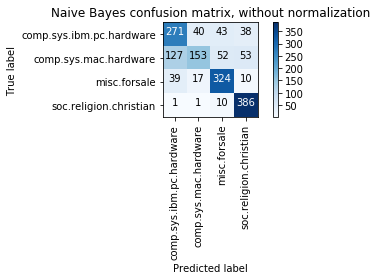

In [115]:
plot_confusion_matrix_4(confusion_q8_nb, title='Naive Bayes confusion matrix')

In [100]:
accuracy_q8_nb = accuracy_score(test_dataset_q8.target, y_pred_q8_nb)
recall_q8_nb = recall_score(test_dataset_q8.target, y_pred_q8_nb, average='weighted')
precision_q8_nb = precision_score(test_dataset_q8.target, y_pred_q8_nb, average='weighted')
f1_score_q8_nb = f1_score(test_dataset_q8.target, y_pred_q8_nb, average='weighted')

In [101]:
print('Accuracy of (Gaussian) Naive Bayes:  ', accuracy_q8_nb)
print('Recall of (Gaussian) Naive Bayes:    ', recall_q8_nb)
print('Precision of (Gaussian) Naive Bayes: ', precision_q8_nb)
print('F1 score of (Gaussian) Naive Bayes:  ', f1_score_q8_nb)

Accuracy of (Gaussian) Naive Bayes:   0.7246006389776358
Recall of (Gaussian) Naive Bayes:     0.7246006389776358
Precision of (Gaussian) Naive Bayes:  0.7231391622931213
F1 score of (Gaussian) Naive Bayes:   0.708882976103418


### Multi class SVM

#### One vs Rest

In [102]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

In [103]:
clf_multiclass_1vsR = OneVsRestClassifier(LinearSVC(random_state=42))
clf_multiclass_1vsR.fit(X_train_q8_lsa, train_dataset_q8.target)
y_pred_q8_multiclass_1vsR = clf_multiclass_1vsR.predict(X_test_q8_lsa)

In [104]:
confusion_q8_multiclass_1vsR = confusion_matrix(test_dataset_q8.target, y_pred_q8_multiclass_1vsR)

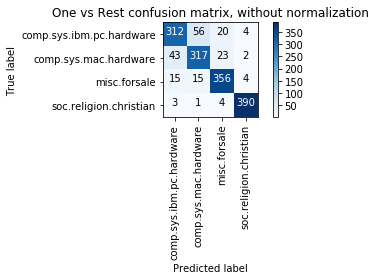

In [105]:
def plot_confusion_matrix_4(cm, title, cmap = plt.cm.Blues):
    ctgrs = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
                 'misc.forsale', 'soc.religion.christian']
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title + ', without normalization')
    plt.colorbar()
    tick_marks = np.arange(len(ctgrs))
    plt.xticks(tick_marks, ctgrs, rotation=90)
    plt.yticks(tick_marks, ctgrs)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix_4(confusion_q8_multiclass_1vsR, title='One vs Rest confusion matrix')

In [108]:
accuracy_q8_1vsR = accuracy_score(test_dataset_q8.target, y_pred_q8_multiclass_1vsR)
recall_q8_1vsR = recall_score(test_dataset_q8.target, y_pred_q8_multiclass_1vsR, average='macro')
precision_q8_1vsR = precision_score(test_dataset_q8.target, y_pred_q8_multiclass_1vsR, average='macro')
f1_score_q8_1vsR = f1_score(test_dataset_q8.target, y_pred_q8_multiclass_1vsR, average='macro')

In [109]:
print('Accuracy of One vs Rest SVM:  ', accuracy_q8_1vsR)
print('Recall of One vs Rest SVM:    ', recall_q8_1vsR)
print('Precision of One vs Rest SVM: ', precision_q8_1vsR)
print('F1 score of One vs Rest SVM:  ', f1_score_q8_1vsR)

Accuracy of One vs Rest SVM:   0.8785942492012779
Recall of One vs Rest SVM:     0.878003750257878
Precision of One vs Rest SVM:  0.8774364603846514
F1 score of One vs Rest SVM:   0.8775268931698303


#### One vs One

In [110]:
clf_multiclass_1vs1 = OneVsOneClassifier(LinearSVC(random_state=42))
clf_multiclass_1vs1.fit(X_train_q8_lsa, train_dataset_q8.target)
y_pred_q8_multiclass_1vs1 = clf_multiclass_1vs1.predict(X_test_q8_lsa)

In [111]:
confusion_q8_multiclass_1vs1 = confusion_matrix(test_dataset_q8.target, y_pred_q8_multiclass_1vs1)

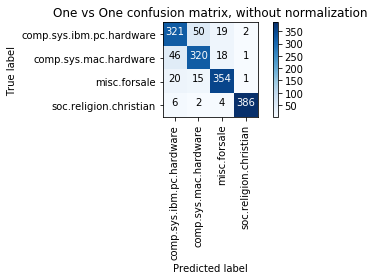

In [112]:
plot_confusion_matrix_4(confusion_q8_multiclass_1vs1, title='One vs One confusion matrix')

In [113]:
accuracy_q8_1vs1 = accuracy_score(test_dataset_q8.target, y_pred_q8_multiclass_1vs1)
recall_q8_1vs1 = recall_score(test_dataset_q8.target, y_pred_q8_multiclass_1vs1, average='macro')
precision_q8_1vs1 = precision_score(test_dataset_q8.target, y_pred_q8_multiclass_1vs1, average='macro')
f1_score_q8_1vs1 = f1_score(test_dataset_q8.target, y_pred_q8_multiclass_1vs1, average='macro')

In [114]:
print('Accuracy of One vs One SVM:  ', accuracy_q8_1vs1)
print('Recall of One vs One SVM:    ', recall_q8_1vs1)
print('Precision of One vs One SVM: ', precision_q8_1vs1)
print('F1 score of One vs One SVM:  ', f1_score_q8_1vs1)

Accuracy of One vs One SVM:   0.8824281150159744
Recall of One vs One SVM:     0.8818969840281757
Precision of One vs One SVM:  0.8824033498829625
F1 score of One vs One SVM:   0.882114049610867
